In [1]:
!pip install dipy

In [2]:
import numpy as np
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.imwarp import DiffeomorphicMap
from dipy.align.metrics import CCMetric
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
import os.path
from dipy.viz import regtools

C:\Users\pha\anaconda3\envs\bvenv\lib\site-packages\dipy\viz\__init__.py:31: UserWarning: You do not have FURY installed. Some visualization functions might not work for you. For installation instructions, please visit: https://fury.gl/
  warnings.warn(


In [12]:
from dipy.segment.mask import median_otsu
stanford_b0_masked, stanford_b0_mask = median_otsu(stanford_b0,
                                                   median_radius=4,
                                                   numpass=4)
syn_b0_masked, syn_b0_mask = median_otsu(syn_b0, median_radius=4, numpass=4)

static = stanford_b0_masked
static_affine = stanford_b0_affine
moving = syn_b0_masked
moving_affine = syn_b0_affine

ValueError: threshold_otsu is expected to work with images having more than one color. The input image seems to have just one color 0.

In [24]:
from glob import glob

data_files = glob('../../brainmask_nii/*.nii')
data_files.sort()

i = 1

ixi_idx = 0
oas1_idx = 314
oas3_idx = 800

ixi = data_files[ixi_idx+i]
oas1 = data_files[oas1_idx+i]
oas3 = data_files[oas3_idx+i]

In [27]:
stanford_b0, stanford_b0_affine = load_nifti(ixi)
stanford_b0 = np.squeeze(stanford_b0)[..., 0]

### bic-berkeley.github.io
https://bic-berkeley.github.io/psych-214-fall-2016/dipy_registration.html

In [35]:
# Set up our usual routines and configuration
import os
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import matplotlib.pyplot as plt
# - set gray colormap and nearest neighbor interpolation by default
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'
import nibabel as nib

In [36]:
from dipy.viz import regtools
from dipy.align.imaffine import (AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)

In [37]:
>>> moving_img = nib.load(ixi)
>>> template_img = nib.load(oas1)

In [40]:
>>> moving_data = moving_img.get_fdata()
>>> moving_affine = moving_img.affine
>>> template_data = template_img.get_fdata()
>>> template_affine = template_img.affine

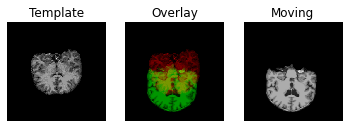

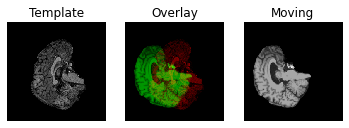

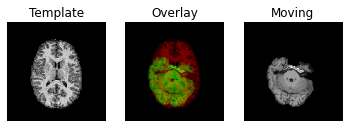

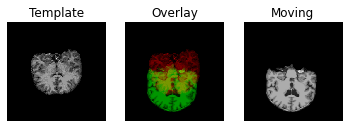

In [42]:
>>> identity = np.eye(4)
>>> affine_map = AffineMap(identity,
...                        template_data.shape, template_affine,
...                        moving_data.shape, moving_affine)
>>> resampled = affine_map.transform(moving_data)
>>> regtools.overlay_slices(template_data, resampled, None, 0,
...                         "Template", "Moving")
>>> regtools.overlay_slices(template_data, resampled, None, 1,
...                         "Template", "Moving")
>>> regtools.overlay_slices(template_data, resampled, None, 2,
...                         "Template", "Moving")

In [43]:
# The mismatch metric
nbins = 32
sampling_prop = None
metric = MutualInformationMetric(nbins, sampling_prop)

In [44]:
# The optimization strategy
level_iters = [10, 10, 5]
sigmas = [3.0, 1.0, 0.0]
factors = [4, 2, 1]

In [45]:
affreg = AffineRegistration(metric=metric,
                            level_iters=level_iters,
                            sigmas=sigmas,
                            factors=factors)

In [46]:
transform = TranslationTransform3D()
params0 = None
translation = affreg.optimize(template_data, moving_data, transform, params0,
                              template_affine, moving_affine)

Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]


In [47]:
translation.affine

array([[ 1.    ,  0.    ,  0.    ,  5.5288],
       [ 0.    ,  1.    ,  0.    ,  3.6529],
       [ 0.    ,  0.    ,  1.    , 38.8881],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

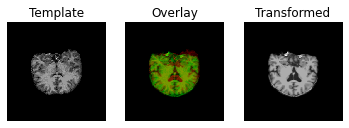

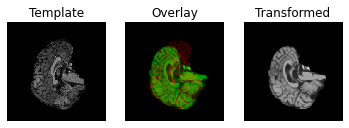

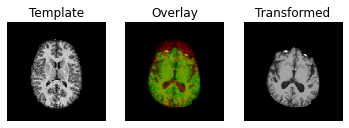

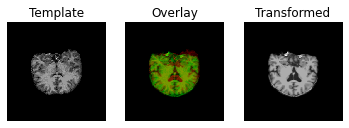

In [48]:
transformed = translation.transform(moving_data)
regtools.overlay_slices(template_data, transformed, None, 0,
                        "Template", "Transformed")
regtools.overlay_slices(template_data, transformed, None, 1,
                        "Template", "Transformed")
regtools.overlay_slices(template_data, transformed, None, 2,
                        "Template", "Transformed")

In [49]:
transform = RigidTransform3D()
rigid = affreg.optimize(template_data, moving_data, transform, params0,
                        template_affine, moving_affine,
                        starting_affine=translation.affine)

Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]


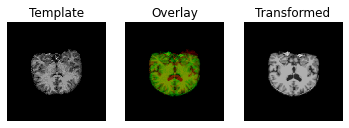

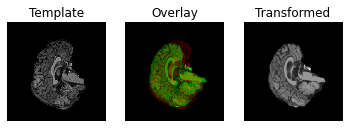

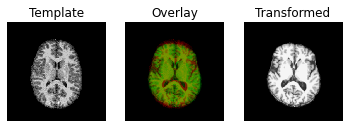

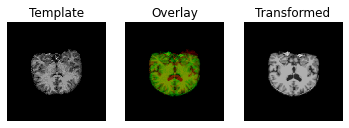

In [50]:
>>> transformed = rigid.transform(moving_data)
>>> regtools.overlay_slices(template_data, transformed, None, 0,
...                         "Template", "Transformed")
>>> regtools.overlay_slices(template_data, transformed, None, 1,
...                         "Template", "Transformed")
>>> regtools.overlay_slices(template_data, transformed, None, 2,
...                         "Template", "Transformed")

In [51]:
transform = AffineTransform3D()
# Bump up the iterations to get an more exact fit
affreg.level_iters = [1000, 1000, 100]
affine = affreg.optimize(template_data, moving_data, transform, params0,
                         template_affine, moving_affine,
                         starting_affine=rigid.affine)

Optimizing level 2 [max iter: 1000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


In [52]:
>>> affine.affine

array([[ 0.9979, -0.0707,  0.1164,  5.9566],
       [ 0.1482,  0.8337, -0.2548, -6.2717],
       [-0.1187,  0.3297,  0.9083, 44.7975],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

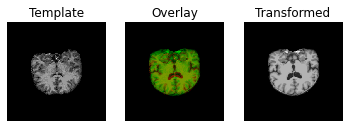

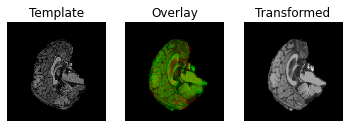

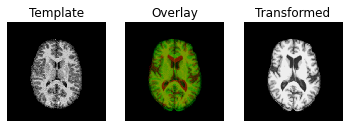

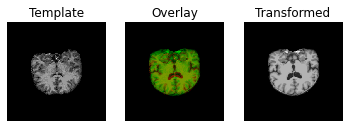

In [53]:
>>> transformed = affine.transform(moving_data)
>>> regtools.overlay_slices(template_data, transformed, None, 0,
...                         "Template", "Transformed")
>>> regtools.overlay_slices(template_data, transformed, None, 1,
...                         "Template", "Transformed")
>>> regtools.overlay_slices(template_data, transformed, None, 2,
...                         "Template", "Transformed")

In [54]:
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.imwarp import DiffeomorphicMap
from dipy.align.metrics import CCMetric

In [55]:
# The mismatch metric
metric = CCMetric(3)
# The optimization strategy:
level_iters = [10, 10, 5]
# Registration object
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters)

In [56]:
mapping = sdr.optimize(template_data, moving_data, template_affine,
                       moving_affine, affine.affine)

In [57]:
warped_moving = mapping.transform(moving_data)

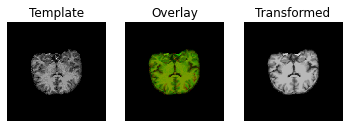

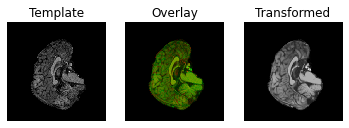

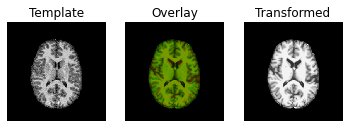

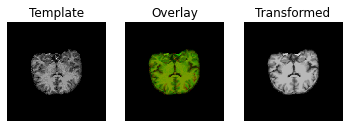

In [59]:
regtools.overlay_slices(template_data, warped_moving, None, 0,
                        "Template", "Transformed")
regtools.overlay_slices(template_data, warped_moving, None, 1,
                        "Template", "Transformed")
regtools.overlay_slices(template_data, warped_moving, None, 2,
                        "Template", "Transformed")

In [2]:
from src.registration import *
from glob import glob

data_files = glob('../../brainmask_nii/*.nii')
data_files.sort()

i = 0

ixi_idx = 0
oas1_idx = 314
oas3_idx = 800

ixi = data_files[ixi_idx+i]
oas1 = data_files[oas1_idx+i]
oas3 = data_files[oas3_idx+i]

In [ ]:
affreg = Registration(template=ixi, moving=oas1).optimize()

Transformation.
Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]


In [ ]:
warped_moving = affreg.transform(nib.load(oas1).get_fdata())

In [ ]:
regtools.overlay_slices(template_data, warped_moving, None, 0,
                        "Template", "Transformed")
regtools.overlay_slices(template_data, warped_moving, None, 1,
                        "Template", "Transformed")
regtools.overlay_slices(template_data, warped_moving, None, 2,
                        "Template", "Transformed")

In [ ]:
data_files = list(filter(lambda x: x.split('\\')[-1][:3] == 'IXI', glob('../../../brainmask_nii/*.nii')))
data_files.sort()

template = data_files.pop(0)

for moving in data_files:
    print(moving)

In [ ]:
data_files = list(filter(lambda x: x.split('\\')[-1][:3] == 'IXI', glob('../../../brainmask_nii/*.nii')))
template = data_files.pop(0)

for moving in data_files:
    affreg = Registration(template=template, moving=moving)
    warped = affreg.transform(moving.get_fdata())
    np.save(f'{moving.split('\\')[-1].split('.')[0]}_registered.npy')